In [359]:
# Importing the necessary libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt

# Creating Word Cloud and removing stop words
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
import string
from collections import Counter


from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [361]:
# Importing the data
train_data = pd.read_csv("CU Boulder/Intro to Deep Learning/Week 4/NLP Disaster Tweets Project/Data/train.csv")
test_data = pd.read_csv("CU Boulder/Intro to Deep Learning/Week 4/NLP Disaster Tweets Project/Data/test.csv")

1) Exploratory Data Analysis

In [363]:
# Train data has id, keyword (can be blank), location (can be blank), text/tweet
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


id and target are integars of 0 and 1. Keyword, location, and text are strings that are data type object. 

In [365]:
# Showing the data type for each of the columns
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In terms of missing data there is a lot of missing data for location and minimal for keyword. 

The model I will be creating will use exclusively text so I will ignore the issue of missing values for keyword and location

In [367]:
# Check for missing values in train and test datasets
print("Missing Values in Train DataFrame:")
print(train_data.isnull().sum())

print("\nMissing Values in Test DataFrame:")
print(test_data.isnull().sum())

Missing Values in Train DataFrame:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing Values in Test DataFrame:
id             0
keyword       26
location    1105
text           0
dtype: int64


Providing the count and shape of the data

Shape of Train Data: (7613, 5)

Missing Values:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Target Distribution:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


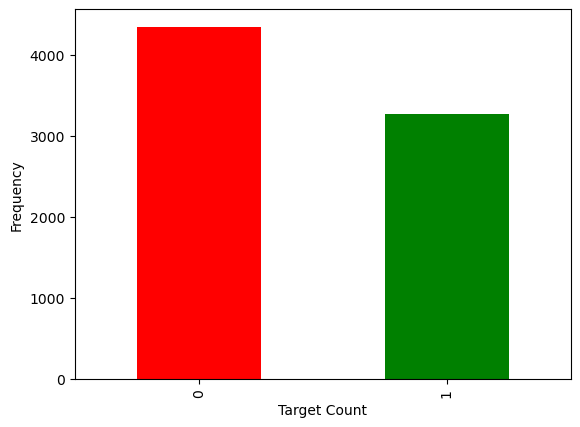

In [369]:
# Providing the shape and counts of the dat
print("Shape of Train Data:", train_data.shape)
print("\nMissing Values:\n", train_data.isnull().sum())
print("\nTarget Distribution:")
print(train_data['target'].value_counts(normalize=True))


# Providing the number count of target values
train_data['target'].value_counts()

target_counts = train_data['target'].value_counts()
target_counts.plot(kind = 'bar', color = ["red", "green"])
plt.xlabel("Target Count")
plt.ylabel("Frequency")

plt.show()

These are the top 20 most frequent words in the train data

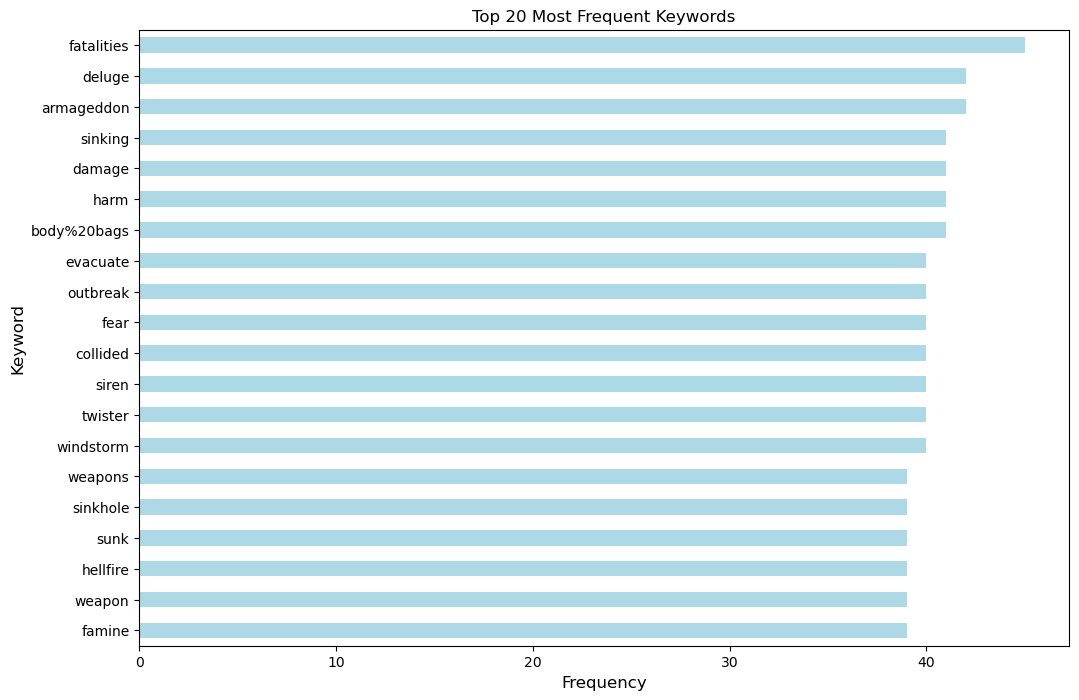

In [371]:
# Counting the top 20 keywords
keyword_counts = train_data['keyword'].value_counts().head(20)

# Creating the plot of the top 20 key words
plt.figure(figsize=(12, 8))
keyword_counts.sort_values().plot(kind='barh', color='lightblue')  # Sắp xếp giá trị tăng dần
plt.title('Top 20 Most Frequent Keywords', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Keyword', fontsize=12)
plt.show()

In [373]:
# Test data has everything Train has except the target
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


2) Data Cleaning for model training

Stop words are filler words such as "a", "the", "with" that do not provide much in terms of model training and testing. So I am removing those words from the data. Removing those words allow the model to train more efficiently and accurately. 

In [375]:
# Cleaning function
def clean_text(text):
    # Lowercase the text

    # Load stop words globally
    stop_words = set(stopwords.words('english'))
    
    text = text.lower()
    # Remove punctuation
    text = re.sub(f"[{string.punctuation}]", "", text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stop words
    filtered_words = [word for word in words if word not in stop_words]
    # Join words back into a single string
    return " ".join(filtered_words)

In [377]:
# Removing stop words and punctuation
train_data['text'] = train_data['text'].apply(clean_text)
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse nearb...,1
7609,10870,NaN,NaN,ariaahrary thetawniest control wild fires cali...,1
7610,10871,NaN,NaN,m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj,1
7611,10872,NaN,NaN,police investigating ebike collided car little...,1


Word Cloud plots are created here to show the prominent words from the 1 and 0 targets for tweets.

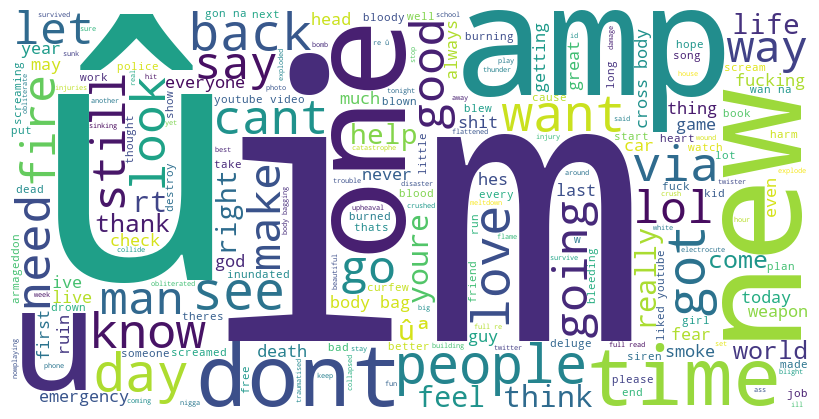

In [379]:
word_cloud0 = pd.DataFrame(train_data['text'][train_data['target'] == 0])
word_cloud0 = ' '.join(word_cloud0['text'])


word_cloud0 = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(word_cloud0)
#word_cloud0
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(word_cloud0)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

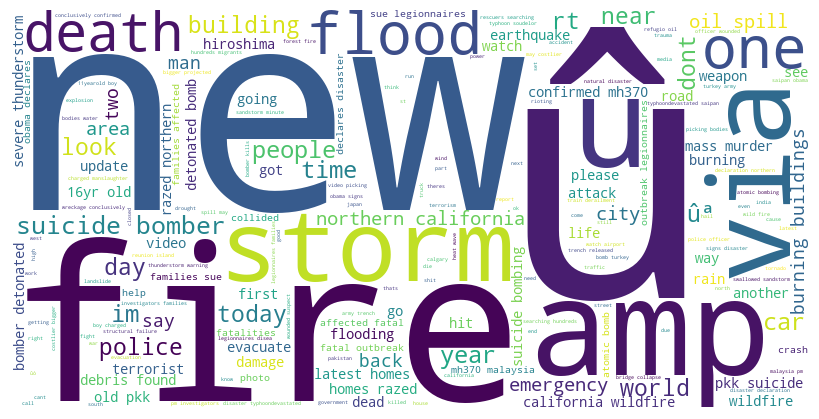

In [381]:
word_cloud1 = pd.DataFrame(train_data['text'][train_data['target'] == 1])
word_cloud1 = ' '.join(word_cloud1['text'])


word_cloud1 = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(word_cloud1)
#word_cloud0
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(word_cloud1)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [383]:
# Counting the number of unique words in all the tweets to determine what num_words I should give to my model
tweet_string = ' '.join(train_data['text'])

words = re.findall(r'\b[a-z]+\b', tweet_string)

# Use a set to get unique words
unique_words = set(words)

# Count the unique words
unique_count = len(unique_words)

unique_count

16959

Splitting the model training data into train and testing. I will be doing a 70/30 split.

In [385]:
temp_train_data = train_data.drop('target', axis = 1)
# print(temp_train_data.head())

# splitting up the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(temp_train_data, train_data['target'], test_size=0.3, random_state=42)

This is an important step of tokenizing the data 

In [387]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=unique_count, oov_token='<OOV>')

# Fit tokenizer on training data
tokenizer.fit_on_texts(X_train['text'])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train['text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['text'])

In [389]:
# Pad sequences
max_seq_length = 50 
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length, padding='post', truncating='post')


3) Model Training

This model is designed for binary classification as the output layer produces a single probability value for binary classification. The size of the vocabulary is found in the input_dim hyper parameter and it equals the number of unique words I found in the data. Output_dim is the dimensionality of the embedded vectors. Each word will represented as a 256-dimensional vector.

In [391]:
model = Sequential([
    Embedding(input_dim=unique_count, output_dim=256),  # Embedding layer
    LSTM(units=128, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


I will be using epoch of 10 as the standard. Then I will plot the accuracy and loss to see if there is an ideal epoch number for this model.

In [393]:
# Train the model
history = model.fit(
    X_train_padded,       # Padded training sequences
    y_train,              # Training labels
    validation_data=(X_test_padded, y_test),  # Validation data
    epochs=10,            # Number of epochs
    batch_size=32,        # Batch size
    verbose=1             # Display progress (1 for detailed, 0 for silent)
)

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5609 - loss: 0.6878 - val_accuracy: 0.5771 - val_loss: 0.6814
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5656 - loss: 0.6867 - val_accuracy: 0.5771 - val_loss: 0.6878
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5621 - loss: 0.6878 - val_accuracy: 0.5771 - val_loss: 0.6812
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5657 - loss: 0.6873 - val_accuracy: 0.5771 - val_loss: 0.6819
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.5733 - loss: 0.6828 - val_accuracy: 0.5771 - val_loss: 0.6814
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5674 - loss: 0.6860 - val_accuracy: 0.5771 - val_loss: 0.6833
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5743 - loss: 0.6833 - val_accuracy: 0.5771 - val_loss: 0.6816
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5613 - loss: 0.6864 - val_accu

In [394]:
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose = 1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5713 - loss: 0.6829
Test Loss: 0.6812915802001953
Test Accuracy: 0.5770577788352966


Plotting the lose curves.

Because the accuracy and loss are stagnant there really is not an ideal number of epochs. So for this model I will leave it at 10.

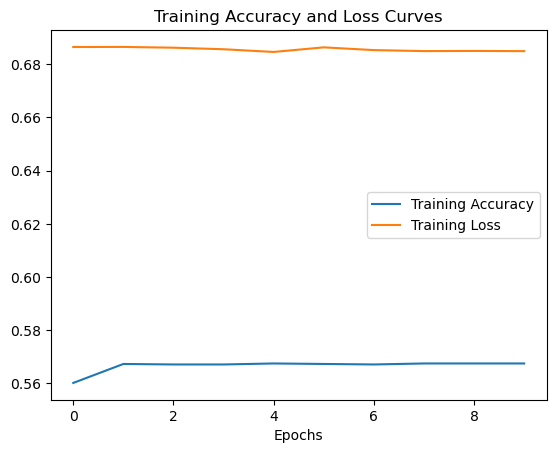

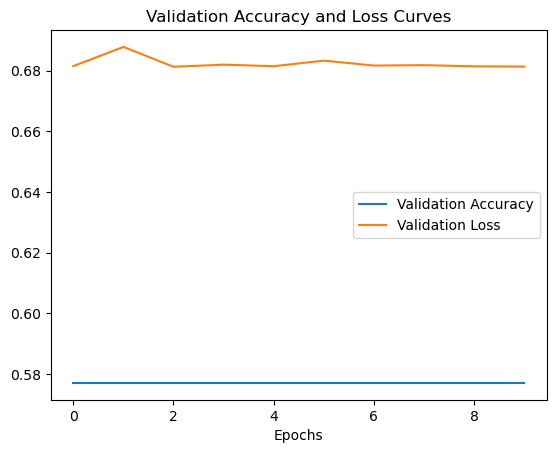

In [395]:
# Getting the Training accuracy and loss values
accuracy = history.history["accuracy"]
loss = history.history["loss"]

# Getting the Validation accuracy and loss values
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

epochs = range(len(history.history["accuracy"]))

# Plot the loss and accuracy curves
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, loss, label="Training Loss")
plt.title("Training Accuracy and Loss Curves")
plt.xlabel("Epochs")
plt.legend()

# Plot the loss and accuracy curves of validation data
plt.figure()
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Validation Accuracy and Loss Curves")
plt.xlabel("Epochs")
plt.legend()

Now that the model is created I will be generating predictions with the test data and seeing how the model performs with data it has not seen yet.

Here is the model making the predictions and classifying any prediction greater than 0.5 as a 1. Everything else is a 0.

I am also printing out the first 5 values to show the tweet, actual label, and predicted value. 

As you can see the movel was correct 3/5. The model predicted 0 for all these tweets.

In [396]:
# Generate Predictions
predictions = model.predict(X_test_padded)

predicted_classes = (predictions > 0.5).astype("int32")

# Example: Compare predictions with actual labels
for i in range(5):  # Display the first 5 results
    print(f"Tweet: {X_test.iloc[i]['text']}")
    print(f"Actual Label: {y_test.iloc[i]}, Predicted: {predicted_classes[i][0]}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Tweet: new weapon cause unimaginable destruction
Actual Label: 1, Predicted: 0
Tweet: famping things gishwhes got soaked deluge going pads tampons thx mishacollins
Actual Label: 0, Predicted: 0
Tweet: dt georgegalloway rt galloway4mayor ûïthe col police catch pickpocket liverpool stree httptcovxin1goq4q
Actual Label: 1, Predicted: 0
Tweet: aftershock back school kick great want thank everyone making possible great night
Actual Label: 0, Predicted: 0
Tweet: response trauma children addicts develop defensive self one decreases vulnerability 3
Actual Label: 0, Predicted: 0


4) Generating predictions on the test data

First I need to clean the test data by removing stop words and then tokenizing the tweets.

In [397]:
# First I need to clean the test_data
# Removing stop words and punctuation
test_data['text'] = test_data['text'].apply(clean_text)
test_data

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 china taiwan
...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,NaN,storm ri worse last hurricane cityamp3others h...
3260,10868,NaN,NaN,green line derailment chicago httptcoutbxlcbiuy
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo httpt...


In [398]:
# Fit tokenizer on the data
tokenizer = Tokenizer(num_words=unique_count)
tokenizer.fit_on_texts(test_data['text'])
sequences = tokenizer.texts_to_sequences(test_data['text'])

# Calculate lengths of all sequences
seq_lengths = [len(seq) for seq in sequences]

# Visualize or calculate max and percentiles
import numpy as np
max_seq_length = int(np.percentile(seq_lengths, 95))  # Covers 95% of tweets
print(f"95th percentile sequence length: {max_seq_length}")

95th percentile sequence length: 16


In [399]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=unique_count, oov_token='<OOV>')

# Fit tokenizer on training data
tokenizer.fit_on_texts(X_train['text'])

# Convert text to sequences
test_seq = tokenizer.texts_to_sequences(test_data['text'])

In [400]:
# Pad sequences
max_seq_length = 50
test_seq_padded = pad_sequences(test_seq, maxlen=max_seq_length, padding='post', truncating='post')

Generating the predictions on the test data that will be used in the submission.

In [401]:
# Generate Predictions
predictions = model.predict(test_seq_padded)

predicted_classes = (predictions > 0.5).astype("int32")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


Now that the predictions are generated I am combining the test_data['id'] with the predictions so that it can be submitted to Kaggle.

In [402]:
# Converting the predicted values into a format that can be combined with the test_data['id'] so that it can be submitted to Kaggle.
predicted_classes = np.array(predicted_classes).ravel()

In [403]:
submission = pd.DataFrame({'id': test_data['id'], 'target': predicted_classes})
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [309]:
submission.to_csv(r'C:\Users\bendu\CU Boulder\Intro to Deep Learning\Week 4\NLP Disaster Tweets Project\Submission\submission.csv', index=False)